In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F




In [2]:
from torch.utils.data import Dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
            

    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)
        transforms = Compose([ToTensor()])
        im = transforms(im)
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [3]:
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}

training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)


/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73
/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73


In [4]:

z = 10 # groups
a = 15 # attributes
k = 5 # top k 


G = np.random.randn(z, a)
W = np.random.randn(z, k)

   
def projection_simplex_sort(v, z=1):
    '''
    Rescales and normalizes the G matrix
    '''
    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 256,3)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        
        self.features = [self.conv1, self.conv2, self.conv3, self.conv4]
        
        # self.fc1 = nn.Linear(14400, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(256, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = self.pool(F.tanh(self.conv4(x)))
        # Adding 1 more conv, a GAP and a final linear layer for CAM
        x = F.tanh(self.conv5(x))
        features = x
        x = self.GAP(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x) 
        
        g = g.repeat((1, 1, k))
        
        y = g * self.W_
        
        y, _ = y.max(axis=2)
        
        y = torch.transpose(y, 1, 0)
        
        y = torch.sum(y, axis=0)
        
        return (torch.sigmoid(y), x, features)

    
model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)

criterion = torch.nn.L1Loss(reduction='sum')

criterion1 = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)
# epoch = 0




In [6]:
model.load_state_dict(torch.load(f'../data/models/end_to_end_v2_CAM_2.pt'))

RuntimeError: Error(s) in loading state_dict for net:
	size mismatch for G_: copying a param with shape torch.Size([4, 15]) from checkpoint, the shape in current model is torch.Size([10, 15]).
	size mismatch for W_: copying a param with shape torch.Size([4, 5]) from checkpoint, the shape in current model is torch.Size([10, 5]).

In [41]:
# Perform training
for epoch in range(1000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)

        optimizer.zero_grad()

        (y_pred, attributes_pred, features) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), data["labels"][:, :15].to(device))
        
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

Epoch:  1 ; running-loss:  314.6682127725965
Epoch:  2 ; running-loss:  305.3641726778907
Epoch:  3 ; running-loss:  295.7363199552553
Epoch:  4 ; running-loss:  283.4830538110959
Epoch:  5 ; running-loss:  266.69183942080684
Epoch:  6 ; running-loss:  244.54214418722913
Epoch:  7 ; running-loss:  221.04747523097723
Epoch:  8 ; running-loss:  203.0060020603738
Epoch:  9 ; running-loss:  193.57842901588356
Epoch:  10 ; running-loss:  192.2321071641915
Epoch:  11 ; running-loss:  190.45164478539579
Epoch:  12 ; running-loss:  189.2141192987454
Epoch:  13 ; running-loss:  190.96874752418245
Epoch:  14 ; running-loss:  189.66524675286678
Epoch:  15 ; running-loss:  190.33628186512922
Epoch:  16 ; running-loss:  188.94693105640593
Epoch:  17 ; running-loss:  189.20082218623816
Epoch:  18 ; running-loss:  190.12298320174986
Epoch:  19 ; running-loss:  190.41844149431563
Epoch:  20 ; running-loss:  189.53073698819816
Epoch:  21 ; running-loss:  189.39644366300448
Epoch:  22 ; running-loss:  1

Epoch:  175 ; running-loss:  188.31819431904574
Epoch:  176 ; running-loss:  188.09007745077767
Epoch:  177 ; running-loss:  188.5974257460469
Epoch:  178 ; running-loss:  188.02155017871283
Epoch:  179 ; running-loss:  187.44217892147253
Epoch:  180 ; running-loss:  187.2096357308001
Epoch:  181 ; running-loss:  188.2512685757063
Epoch:  182 ; running-loss:  186.98260259125956
Epoch:  183 ; running-loss:  188.19153885136205
Epoch:  184 ; running-loss:  187.1923702599908
Epoch:  185 ; running-loss:  186.95549537441934
Epoch:  186 ; running-loss:  187.4339736138261
Epoch:  187 ; running-loss:  186.86948246787546
Epoch:  188 ; running-loss:  187.48162038565349
Epoch:  189 ; running-loss:  186.82083723230014
Epoch:  190 ; running-loss:  187.53752962056885
Epoch:  191 ; running-loss:  187.33182781419043
Epoch:  192 ; running-loss:  186.8767788984138
Epoch:  193 ; running-loss:  188.140687959582
Epoch:  194 ; running-loss:  187.2341559370352
Epoch:  195 ; running-loss:  186.9170616371951
Ep

Epoch:  347 ; running-loss:  187.94582259121088
Epoch:  348 ; running-loss:  187.05207200656736
Epoch:  349 ; running-loss:  187.9329566201519
Epoch:  350 ; running-loss:  186.6917044581756
Epoch:  351 ; running-loss:  186.8971705905966
Epoch:  352 ; running-loss:  186.97360460919808
Epoch:  353 ; running-loss:  186.91503793870118
Epoch:  354 ; running-loss:  188.13609937341272
Epoch:  355 ; running-loss:  188.20829741144863
Epoch:  356 ; running-loss:  186.86940011210754
Epoch:  357 ; running-loss:  188.23625559181093
Epoch:  358 ; running-loss:  187.99191455662128
Epoch:  359 ; running-loss:  187.11032653366001
Epoch:  360 ; running-loss:  187.96017769763418
Epoch:  361 ; running-loss:  188.38858229680375
Epoch:  362 ; running-loss:  186.79826279632562
Epoch:  363 ; running-loss:  186.0052984216483
Epoch:  364 ; running-loss:  186.78896838656465
Epoch:  365 ; running-loss:  186.84072842409375
Epoch:  366 ; running-loss:  186.88517198712805
Epoch:  367 ; running-loss:  188.06528628764

Epoch:  519 ; running-loss:  186.97826628312524
Epoch:  520 ; running-loss:  187.00963024114006
Epoch:  521 ; running-loss:  187.69959142857394
Epoch:  522 ; running-loss:  187.95386955859146
Epoch:  523 ; running-loss:  187.6310347704891
Epoch:  524 ; running-loss:  186.49030114557482
Epoch:  525 ; running-loss:  186.59377653019456
Epoch:  526 ; running-loss:  187.63821894937155
Epoch:  527 ; running-loss:  187.07366545203513
Epoch:  528 ; running-loss:  187.46832267940874
Epoch:  529 ; running-loss:  186.81889835864177
Epoch:  530 ; running-loss:  186.7717553937658
Epoch:  531 ; running-loss:  187.61195869087092
Epoch:  532 ; running-loss:  187.9553848319207
Epoch:  533 ; running-loss:  186.25252594368646
Epoch:  534 ; running-loss:  187.80459600273386
Epoch:  535 ; running-loss:  187.6536659508145
Epoch:  536 ; running-loss:  188.5810724091246
Epoch:  537 ; running-loss:  187.98298527066444
Epoch:  538 ; running-loss:  187.6775757284466
Epoch:  539 ; running-loss:  187.6634850411586

Epoch:  691 ; running-loss:  186.54582041414386
Epoch:  692 ; running-loss:  186.35311239664622
Epoch:  693 ; running-loss:  186.4290355860711
Epoch:  694 ; running-loss:  186.42771299314649
Epoch:  695 ; running-loss:  186.8782057113511
Epoch:  696 ; running-loss:  185.60895108711873
Epoch:  697 ; running-loss:  187.64558982944772
Epoch:  698 ; running-loss:  186.46560888398102
Epoch:  699 ; running-loss:  186.13298458409417
Epoch:  700 ; running-loss:  187.36849858031434
Epoch:  701 ; running-loss:  186.5977410794733
Epoch:  702 ; running-loss:  187.43654939019328
Epoch:  703 ; running-loss:  186.26707335053243
Epoch:  704 ; running-loss:  187.7695124793086
Epoch:  705 ; running-loss:  185.56534557617078
Epoch:  706 ; running-loss:  186.12545515629367
Epoch:  707 ; running-loss:  186.25271131059952
Epoch:  708 ; running-loss:  186.068641065882
Epoch:  709 ; running-loss:  187.4394781470311
Epoch:  710 ; running-loss:  187.47183468009487
Epoch:  711 ; running-loss:  186.47595153591845

Epoch:  863 ; running-loss:  185.70221110910848
Epoch:  864 ; running-loss:  186.04394180409366
Epoch:  865 ; running-loss:  186.24230226428017
Epoch:  866 ; running-loss:  185.76338386026225
Epoch:  867 ; running-loss:  186.9922933881117
Epoch:  868 ; running-loss:  186.39212613830844
Epoch:  869 ; running-loss:  187.13716535009624
Epoch:  870 ; running-loss:  185.88799450135878
Epoch:  871 ; running-loss:  185.74994539583471
Epoch:  872 ; running-loss:  186.97956963417067
Epoch:  873 ; running-loss:  185.81631727026559
Epoch:  874 ; running-loss:  187.08579114447338
Epoch:  875 ; running-loss:  185.63173306414075
Epoch:  876 ; running-loss:  186.02039765980714
Epoch:  877 ; running-loss:  185.93706151626796
Epoch:  878 ; running-loss:  186.27742510186943
Epoch:  879 ; running-loss:  185.67837257138993
Epoch:  880 ; running-loss:  187.27225140777267
Epoch:  881 ; running-loss:  185.45180889610197
Epoch:  882 ; running-loss:  186.85895766096957
Epoch:  883 ; running-loss:  187.50095899

In [34]:
torch.save(model.state_dict(), f'../data/models/end_to_end_v2_CAM1.pt')

In [1]:
## VISUALIZE model output and parameters on test data
def returnCAM(feature_conv, weight_linear, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_linear[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        if (np.max(cam)) != 0:
            cam_img = cam / (np.max(cam))
        else:
            cam_img = cam
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
params = list(model.parameters())

# extract the weights for the linear layer
weight_linear = np.squeeze(params[-2].data.cpu().numpy())
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred, features) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())
    CAMs = returnCAM(features.detach().cpu().numpy(), weight_linear, [i for i in range(0, a)])
    img = data["image"][0].cpu().permute(1, 2, 0).numpy()
    img = img * 255
    height, width, c = img.shape
    for i in range(0, a):
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.5
        file_name = data["name"][0].split('/')[-1]
        file_name = file_name.split('.')[0]
        cv2.imwrite(f'heatmaps/{file_name}_{i}.png', result)
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))
    count += 1
        
predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

plt.imshow(viz)
plt.title("Left col: gt; Right col: pred")

err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
err_perc



NameError: name 'model' is not defined

In [36]:
np.shape(y_pred)

torch.Size([1])

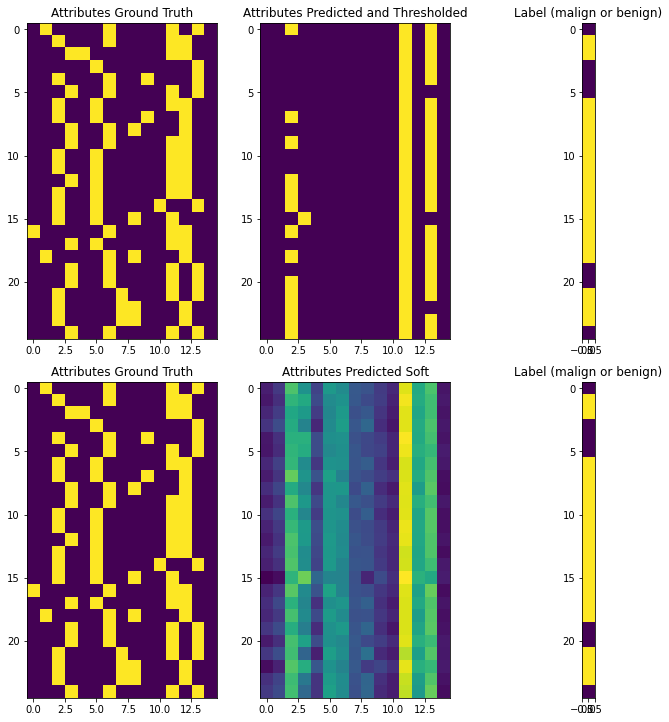

In [12]:
## ALL this should be on TEST set
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(np.expand_dims(viz[:, 0], 1))
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(np.expand_dims(viz[:, 0], 1))
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

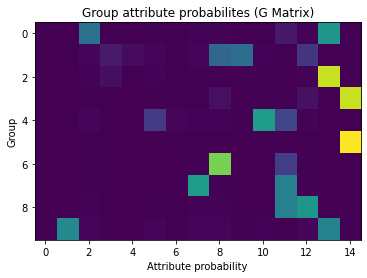

In [11]:
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")

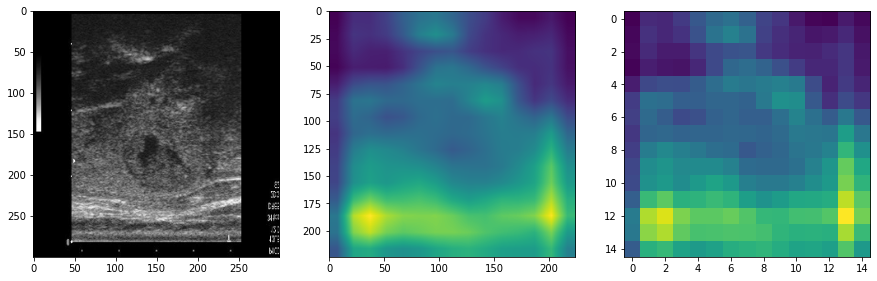

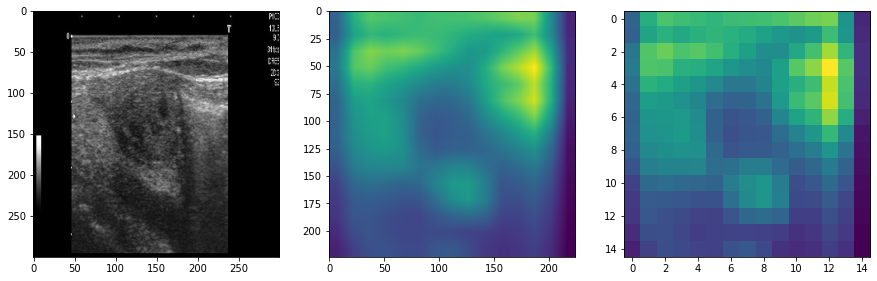

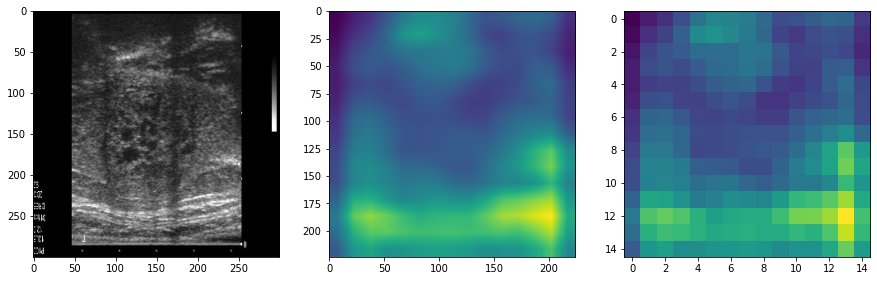

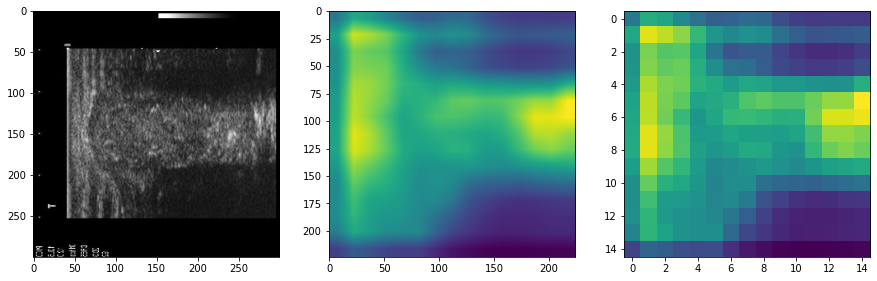

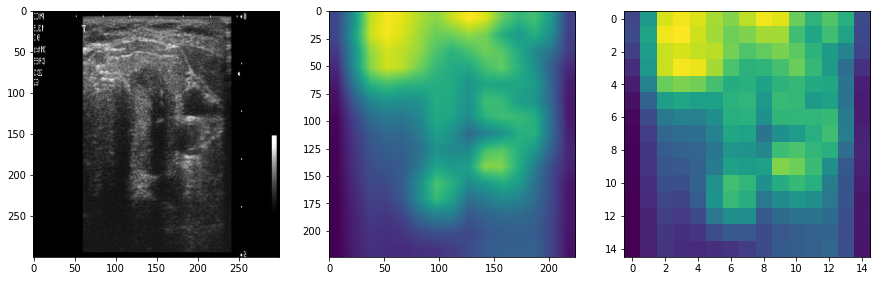

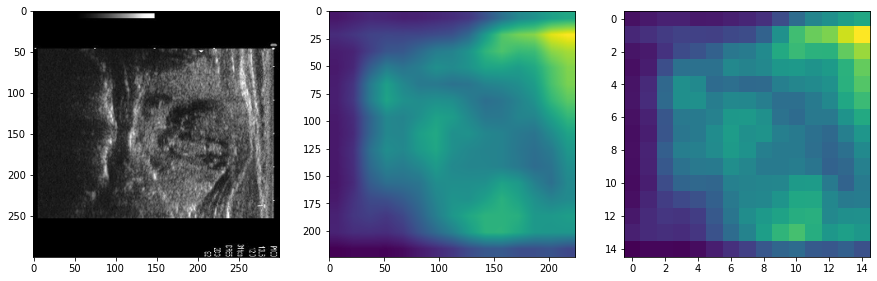

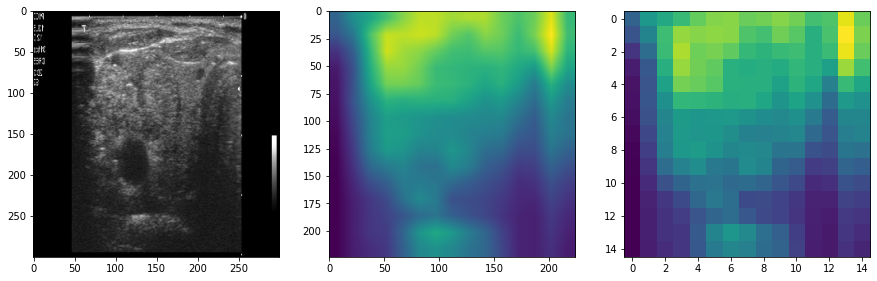

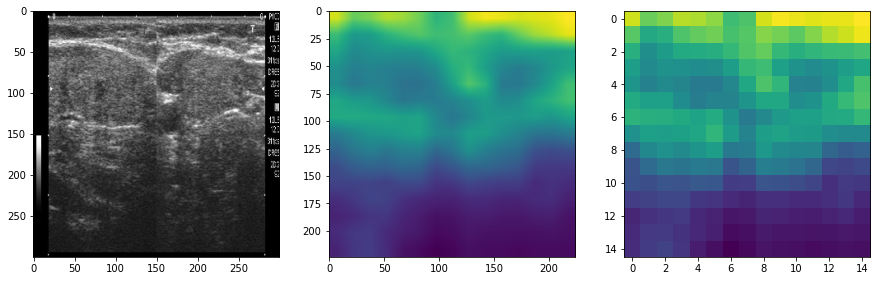

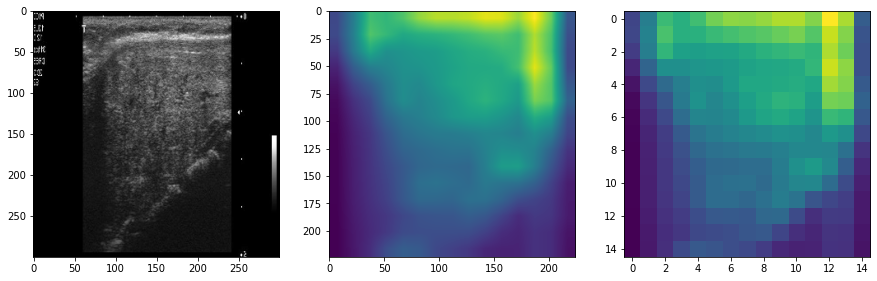

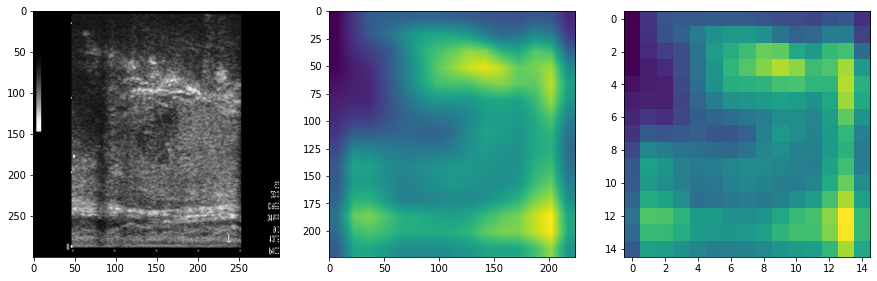

In [35]:

# class CamExtractor():
#     """
#         Extracts cam features from the model
#     """
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
        

#     def forward_pass_on_convolutions(self, x):
#         """
#             Does a forward pass on convolutions, hooks the function at given layer
#         """
#         conv_output = None
#         module_pos = 1
#         for module in self.model.features:
#             x = model.pool(module(x))  # Forward
#             if int(module_pos) == self.target_layer:
#                 conv_output = x  # Save the convolution output on that layer
#             module_pos += 1
#         return conv_output, x

#     def forward_pass(self, x):
#         """
#             Does a full forward pass on the model
#         """
#         conv_output, _ = self.forward_pass_on_convolutions(x)
#         x = F.interpolate(x, (300, 300), mode='bilinear')
#         (x_, _) = model(x)
#         return conv_output, x_

    
# extractor = CamExtractor(model, 4)

# count = 0
# for data in test_generator:
#     y_im_test = data["labels"][:, 15].to(device)
#     x_im_test = data["image"]
#     x_im_test = x_im_test.to(device)


#     [conv_out, x] = extractor.forward_pass_on_convolutions(x_im_test)
#     target = conv_out
#     cam = np.ones((target.shape[1:]), dtype=np.float32)
#     sal_map = np.zeros((224, 224))
#     for i in range(np.shape(target)[1]):
#                 # Unsqueeze to 4D
#                 saliency_map = torch.unsqueeze(torch.unsqueeze(target[0, i, :, :],0),0)
#                 # Upsampling to input size
#                 saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
#                 if saliency_map.max() == saliency_map.min():
#                     continue
#                 # Scale between 0-1
#                 norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
#                 inim = F.interpolate(x_im_test, size=(224, 224), mode='bilinear')
#                 w = extractor.forward_pass(inim * norm_saliency_map)[1]
#                 sal_map += w.cpu().data.numpy() * norm_saliency_map.cpu().data.numpy()[0, 0, :, :]
#                 cam += w.cpu().data.numpy() * target[0, i, :, :].cpu().data.numpy()


#     fig = plt.figure(figsize=(15, 10))

#     ax0 = fig.add_subplot(131)
#     ax0.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))

#     ax1 = fig.add_subplot(132)
#     ax1.imshow(sal_map)

#     ax2 = fig.add_subplot(133)
#     ax2.imshow(cam[0, :, :])
#     count += 1
#     if(count == 10):
#         break


In [1]:
# fig = plt.figure()
# ax0 = fig.add_subplot(121)
# ax0.imshow(sal_map)

# ax1 = fig.add_subplot(122)
# ax1.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))



In [14]:
np.shape(target)[3]

15

In [15]:
source = [i % a for i in range(z*a)]
target = [(i // 15) + 15 for i in range(z*a)]
G[G < 0.05] = 0.0
value = G.flatten().tolist()
print(len(source), len(target), len(value))

color_node = [
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#FF00FF',
              '#00CED1', '#FF8C00', '#BDB76B', '#2F4F4F', '#B8860B'
              ]

color_link = []
link_colors = ['#F08080', '#FFFACD', '#98FB98', '#87CEFA', '#EE82EE',
              '#AFEEEE', '#FFA500', '#F0E68C', '#708090', '#DAA520']

150 150 150


In [18]:
for i in range(z):
    color_link.extend([link_colors[i]] * a)
print(color_link)
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      color = color_node,
      label = ["cystic", "mostly solid", "solid", "spongiform",
               "hyper", "hypo", "iso", "marked",
               "ill-defined", "micro", "spiculated", "smooth",
               "macro", "micro", "non",
               "G1", "G2", "G3", "G4", "G5",
               "G6", "G7", "G8", "G9", "G10"],
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])
fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

['#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#FFFACD', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#98FB98', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#87CEFA', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#EE82EE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#AFEEEE', '#FFA500'